<a href="https://colab.research.google.com/github/ChristianConchari/Strathospheric-ballon-earth-observation-gathered-imagery-classification-through-TinyML/blob/master/classification_model_ballon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and loading the data

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from  tensorflow.keras import optimizers
from keras.utils.vis_utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip /content/gdrive/MyDrive/training_data_balloon.zip
!unzip /content/gdrive/MyDrive/test_data_balloon.zip

Archive:  /content/gdrive/MyDrive/training_data_balloon.zip
   creating: training_data_balloon/
   creating: training_data_balloon/1/
  inflating: training_data_balloon/1/1.png  
  inflating: training_data_balloon/1/29.png  
  inflating: training_data_balloon/1/27.png  
  inflating: training_data_balloon/1/2.png  
  inflating: training_data_balloon/1/25.png  
  inflating: training_data_balloon/1/3.png  
  inflating: training_data_balloon/1/4.png  
  inflating: training_data_balloon/1/5.png  
  inflating: training_data_balloon/1/6.png  
  inflating: training_data_balloon/1/7.png  
  inflating: training_data_balloon/1/8.png  
  inflating: training_data_balloon/1/9.png  
  inflating: training_data_balloon/1/10.png  
  inflating: training_data_balloon/1/11.png  
  inflating: training_data_balloon/1/12.png  
  inflating: training_data_balloon/1/13.png  
  inflating: training_data_balloon/1/14.png  
  inflating: training_data_balloon/1/15.png  
  inflating: training_data_balloon/1/16.png  
 

# Preparing the data

In [4]:
data_generator = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        horizontal_flip=True,
        vertical_flip = True,
        validation_split = 0.2) 

data_test_generator = ImageDataGenerator(rescale = 1./255)

In [5]:
training_data = '/content/training_data_balloon'
test_data = '/content/test_data_balloon'

img_height = 100
img_width = 100
batch_size = 16

train_ds = data_generator.flow_from_directory(
    training_data,
    color_mode='rgb',
    class_mode = "binary",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    subset = "training"
)

val_ds = data_generator.flow_from_directory(
    training_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    color_mode='rgb',
    class_mode = "binary",
    subset = "validation"
)

test_ds = data_test_generator.flow_from_directory(
    test_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    color_mode='rgb',
    class_mode = "binary",
)

Found 1420 images belonging to 2 classes.
Found 355 images belonging to 2 classes.
Found 404 images belonging to 2 classes.


In [6]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 4, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis("off")
  plt.tight_layout()
  plt.show()

[0. 1. 0. 0.]


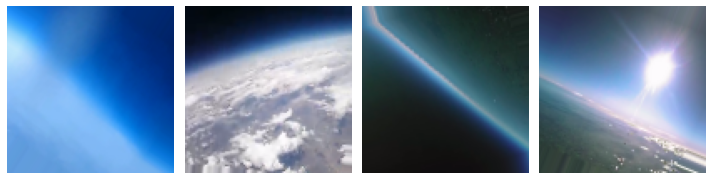

In [9]:
sample_training_images, labels= next(iter(train_ds))
print(labels[:4])
plotImages(sample_training_images[:4])

# Model definition

In [8]:
model_cnn = keras.models.Sequential()

model_cnn.add(keras.layers.Conv2D(32, (3,3), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Activation(keras.activations.relu))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Activation(keras.activations.relu))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Activation(keras.activations.relu))
model_cnn.add(keras.layers.MaxPooling2D((4,4)))

model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(512,  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Dropout(0.5))
model_cnn.add(keras.layers.Activation(keras.activations.relu))
model_cnn.add(keras.layers.Dense(1, activation = "sigmoid"))

model_cnn.build((None, 100, 100, 3))
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 activation (Activation)     (None, 50, 50, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0

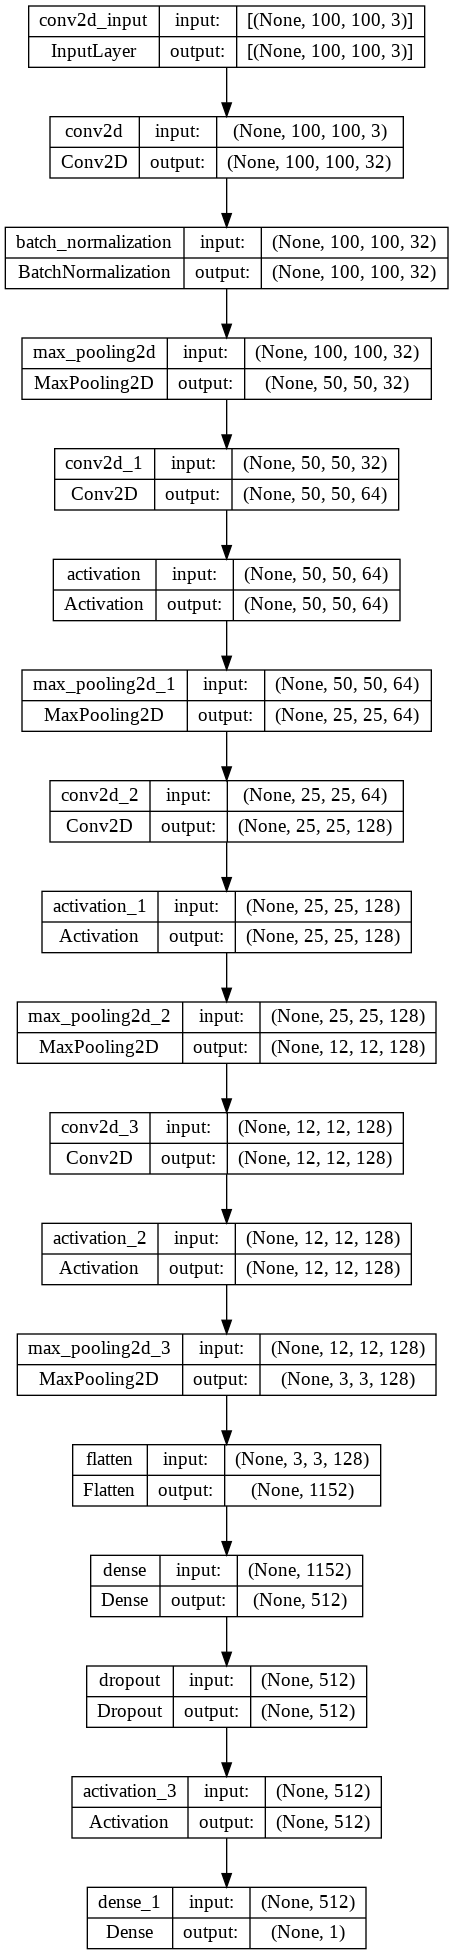

In [10]:
plot_model(model_cnn, to_file='model_cnn.png', show_shapes=True, show_layer_names=True)

In [11]:
optimizer = optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

model_cnn.compile(loss='binary_crossentropy', optimizer =optimizer,
             metrics=['accuracy'])

# Model training

In [12]:
training_samples = train_ds.n
val_samples = val_ds.n

epochs = 15

history_cnn = model_cnn.fit(
    train_ds,
    steps_per_epoch=training_samples // batch_size,
    epochs = epochs,
    validation_data=val_ds,
    validation_steps=val_samples // batch_size,
)

Epoch 1/15
88/88 [==============================] - 58s 541ms/step - loss: 9.2260 - accuracy: 0.6809 - val_loss: 8.3722 - val_accuracy: 0.6562
Epoch 2/15
88/88 [==============================] - 42s 478ms/step - loss: 7.4005 - accuracy: 0.7863 - val_loss: 6.8365 - val_accuracy: 0.8665
Epoch 3/15
88/88 [==============================] - 39s 450ms/step - loss: 6.0963 - accuracy: 0.8305 - val_loss: 5.7100 - val_accuracy: 0.8324
Epoch 4/15
88/88 [==============================] - 40s 450ms/step - loss: 5.1192 - accuracy: 0.8540 - val_loss: 4.8072 - val_accuracy: 0.8949
Epoch 5/15
88/88 [==============================] - 54s 616ms/step - loss: 4.3886 - accuracy: 0.8640 - val_loss: 4.1307 - val_accuracy: 0.8438
Epoch 6/15
88/88 [==============================] - 52s 592ms/step - loss: 3.8078 - accuracy: 0.8853 - val_loss: 3.6400 - val_accuracy: 0.8409
Epoch 7/15
88/88 [==============================] - 42s 480ms/step - loss: 3.3716 - accuracy: 0.8875 - val_loss: 3.2630 - val_accuracy: 0.8352

In [23]:
def visualizacion_resultados(history):
  nepochs = [i for i in range(epochs)]
  fig, ax = plt.subplots(1,2)
  train_acc = history.history["accuracy"]
  train_loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]
  fig.set_size_inches(16, 9)

  ax[0].plot(nepochs, train_acc, "-", label =" Training accuracy")
  ax[0].plot(nepochs, val_acc, "-", label= "Validation accuracy")
  ax[0].set_title("Training & validation accuracy")
  ax[0].legend()
  ax[0].set_xlabel("nEpochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(nepochs, train_loss, "go-", label =" Training Loss")
  ax[1].plot(nepochs, val_loss, "ro-", label= "Validation Loss")
  ax[1].set_title("Training & validation Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()


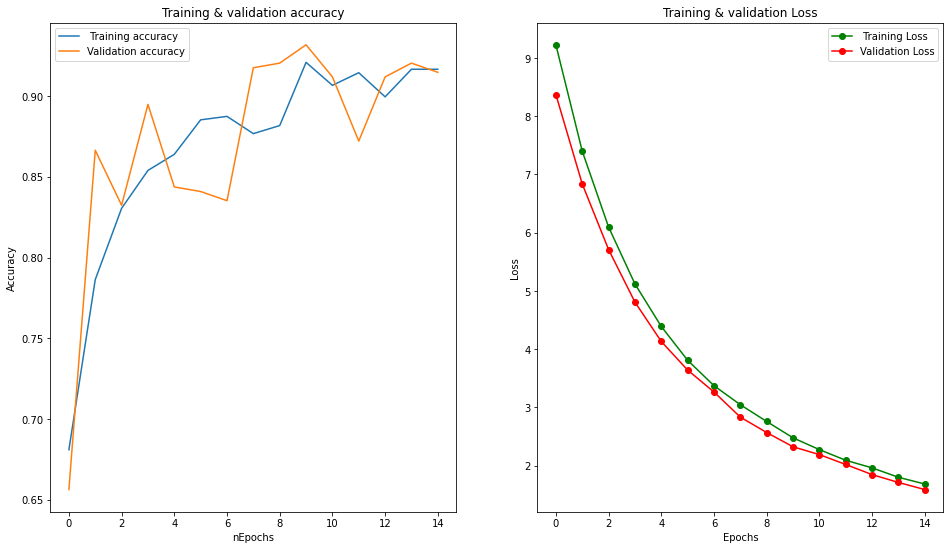

In [24]:
visualizacion_resultados(history_cnn)

# Tensorflow model evaluation

In [47]:
loss, accuracy = model_cnn.evaluate(test_ds)

26/26 [==============================] - 15s 571ms/step - loss: 1.6708 - accuracy: 0.9109


In [109]:
import time
sample_test_images, true_label_id = next(iter(test_ds))

start_time = time.time()
tf_model_predictions = model_cnn(sample_test_images)
end_time = time.time()

time_diff = end_time - start_time
print(f'Processing time: {round(time_diff*1000, 2)} ms')

Processing time: 8.44 ms


In [110]:
predicted_ids = []

for x in tf_model_predictions.numpy(): 
  if x > 0.5:
    predicted_ids.append(1)
  else: 
    predicted_ids.append(0)

print(predicted_ids)
print(true_label_id)

[0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]
[0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.]


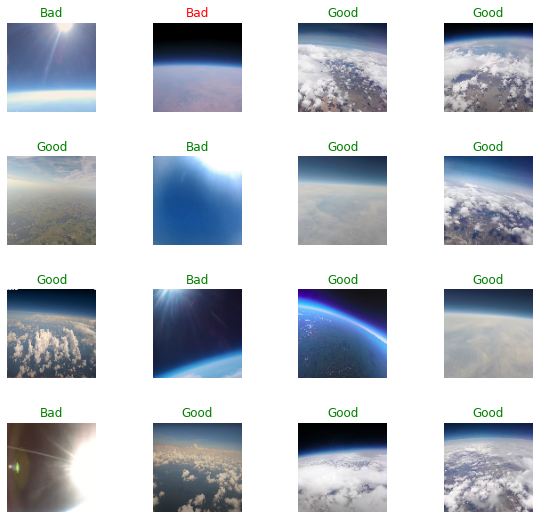

In [111]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(16):
  plt.subplot(4,4,n+1)
  plt.imshow(sample_test_images[n])
  color = "green" if predicted_ids[n] == true_label_id[n] else "red"
  if predicted_ids[n] == 1:
    text = 'Good'
  else:
    text = 'Bad'
  plt.title(text.title(), color=color)
  plt.axis('off')

In [112]:
!mkdir tf_models

model_cnn.save("tf_models/model_cnn.h5")
print("Tensorflow model size")
!ls "tf_models" -lh

mkdir: cannot create directory ‘tf_models’: File exists
Tensorflow model size
total 9.6M
-rw-r--r-- 1 root root 9.6M Oct 19 16:54 model_cnn.h5


# TFLite model quantization

In [113]:
!mkdir "tflite_quantized_models"
TFLITE_MODEL_QUANTIZED = "tflite_quantized_models/cnn_quantized.tflite"

mkdir: cannot create directory ‘tflite_quantized_models’: File exists


In [114]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open(TFLITE_MODEL_QUANTIZED, "wb").write(tflite_quant_model)

print("Tflite model size")
!ls "tflite_quantized_models" -lh

Tflite model size
total 828K
-rw-r--r-- 1 root root 828K Oct 19 16:54 cnn_quantized.tflite


In [117]:
tflite_interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_MODEL_QUANTIZED)

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

tflite_interpreter_quant.resize_tensor_input(input_details[0]['index'], (16, 100, 100, 3))
tflite_interpreter_quant.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter_quant.allocate_tensors()

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

tflite_interpreter_quant.set_tensor(input_details[0]['index'], sample_test_images)

tflite_interpreter_quant.invoke()
start_time = time.time()
tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
end_time = time.time()

time_diff = end_time - start_time

print("\nPrediction results shape:", tflite_q_model_predictions.shape)
print(f'Processing time: {round(time_diff*1000, 2)} ms')

== Input details ==
name: serving_default_conv2d_input:0
shape: [ 16 100 100   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [16  1]
type: <class 'numpy.float32'>

Prediction results shape: (16, 1)
Processing time: 0.1 ms


In [118]:
predicted_ids = []

for x in tflite_q_model_predictions: 
  if x > 0.5:
    predicted_ids.append(1)
  else: 
    predicted_ids.append(0)


print(predicted_ids)
print(true_label_id)

[0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]
[0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.]


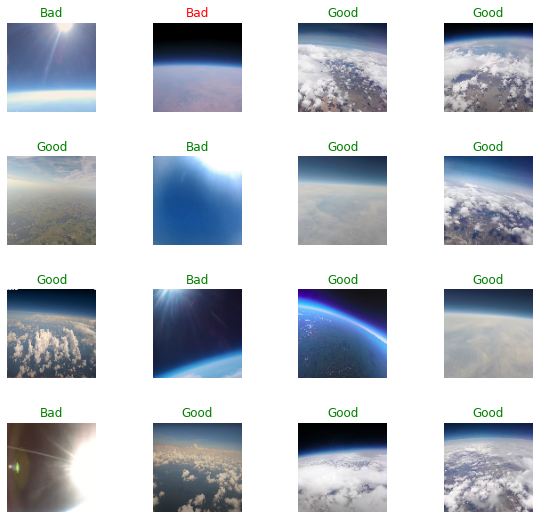

In [119]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(16):
  plt.subplot(4,4,n+1)
  plt.imshow(sample_test_images[n])
  color = "green" if predicted_ids[n] == true_label_id[n] else "red"
  if predicted_ids[n] == 1:
    text = 'Good'
  else:
    text = 'Bad'
  plt.title(text.title(), color=color)
  plt.axis('off')